## Decision tree learning

The goal of a decision tree is to choose splits that maximize the information gain, reducing impurity as much as possible at each step. By choosing the feature and threshold that gives the best split (highest information gain), the tree becomes better at distinguishing between different classes, ultimately leading to better predictions.

In [11]:
# import dataset 

from sklearn import datasets
import numpy as np
iris=datasets.load_iris()
X = iris.data[:, [2, 3]]
y= iris.target

# splitting data to test performance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) # stratification will ensure that both your training and testing sets maintain the same class distribution

from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
sc.fit(X_train)                    # finding mean and std
X_train_std=sc.transform(X_train)  # using same mean std for train and test
X_test_std=sc.transform(X_test)

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    markers=('o','s','^','v','<')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap= ListedColormap(colors[:len(np.unique(y))])
    
    # plot decision surface
    x1_min,x1_max=X[:,0].min()-1, X[:,0].max()+1
    x2_min,x2_max=X[:,1].min()-1, X[:,1].max()+1

    xx1,xx2= np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    #plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0],
                    y= X[y==cl,1],
                    alpha=0.8,
                    c=colors[idx],
                   marker=markers[idx],
                   label=f'Class{cl}', edgecolor='black')
    if test_idx:
        X_test, y_test= X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:,1],
                   c='none', edgecolors='black',alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

### Entropy : Disorder in dataset

To provide a visual intuition, let us visualize the entropy values for different class distributions via the following code:

In a binary class setting, the entropy is 0 if p(i=1|t) = 1 or p(i=0|t) = 0. If the classes are distributed uniformly with p(i=1|t) = 0.5 and p(i=0|t) = 0.5, the entropy is 1. Therefore, we can say that the entropy criterion attempts to maximize the mutual information in the tree.

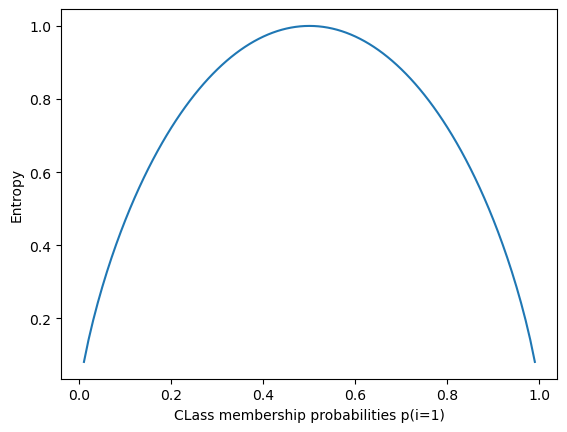

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def entropy(p):
    return -p*np.log2(p)-(1-p)*np.log2((1-p))
x= np.arange(0.0, 1.0, 0.01)
ent= [entropy(p) if p!=0 else None for p in x]
plt.ylabel('Entropy')
plt.xlabel('CLass membership probabilities p(i=1)')
plt.plot(x,ent)
plt.show()

### Gini impurity : criterion to minimize the probability of misclassification

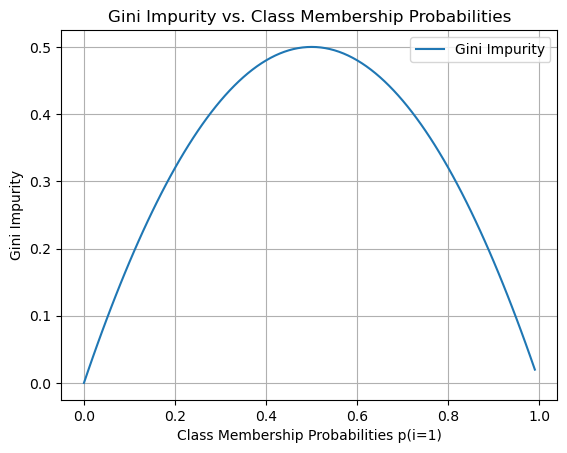

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def gini(p):
    return 2 * p * (1 - p)

# Generate an array of probabilities from 0 to 1 in steps of 0.01
x = np.arange(0.0, 1.0, 0.01)

# Calculate Gini impurity for each probability value
gini = [gini(p) for p in x]

# Plotting the Gini impurity curve
plt.ylabel('Gini Impurity')
plt.xlabel('Class Membership Probabilities p(i=1)')
plt.plot(x, gini, label='Gini Impurity')
plt.legend()
plt.title('Gini Impurity vs. Class Membership Probabilities')
plt.grid()
plt.show()


### Visualising all three impurity criteria

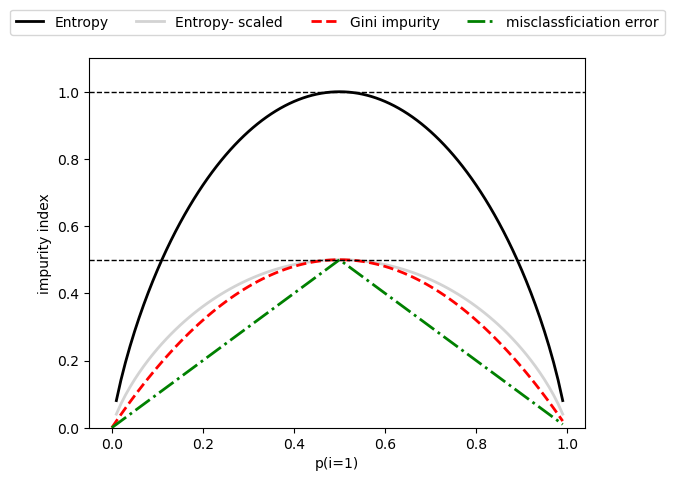

In [9]:
def error(p):
    return 1- np.max([p, 1-p])
def gini(p):
    return 2 * p * (1 - p)
x= np.arange(0.0, 1.0, 0.01)
ent= [entropy(p) if p!=0 else None for p in x]
sc_ent=[e*0.5 if e else None for e in ent]  # scaled version of entropy
err = [error(i) for i in x]
fig= plt.figure()
ax= plt.subplot(111)

for i,lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                       ['Entropy', 'Entropy- scaled', 'Gini impurity','misclassficiation error'], ['-', '-', '--', '-.'], 
                        ['black', 'lightgray', 'red', 'green', 'cyan']):
    line= ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)


ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.show()

## Building a decision tree



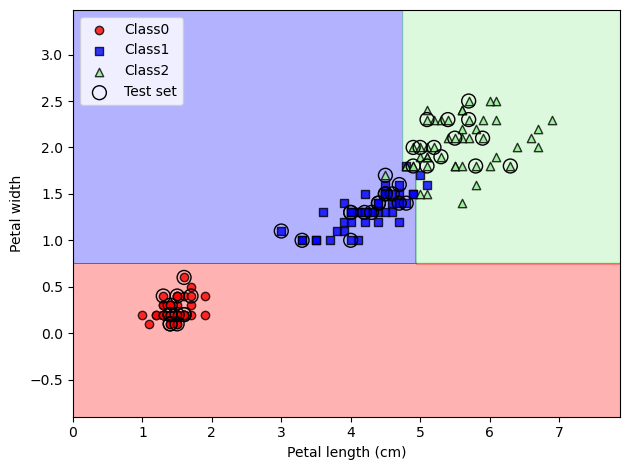

In [13]:

from sklearn.tree import DecisionTreeClassifier
tree_model= DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree_model.fit(X_train, y_train)
X_combined=np.vstack((X_train, X_test))
y_combined= np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree_model, test_idx=range(105,150))
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

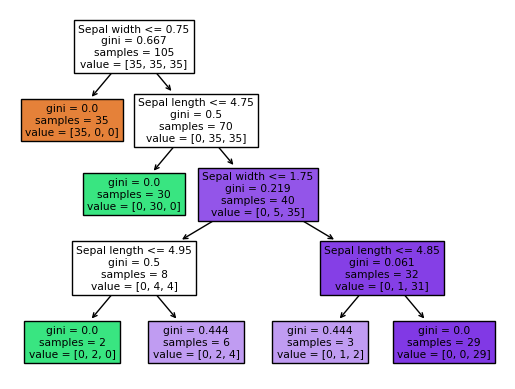

In [14]:
# inbuilt sklearn functionality to visualise

from sklearn import tree
feature_names = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
tree.plot_tree(tree_model, feature_names=feature_names, filled=True)
plt.show()

#### branches on left corresponds to True and right are false

### Post pruning decision trees with cost complexity pruning

In [17]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

## Combining multiple decision trees via random forests


1. Draw a random bootstrap sample of size n (randomly choose n examples from the training dataset with replacement).

2. Grow a decision tree from the bootstrap sample. At each node:

    2.1 Randomly select d features without replacement.
    
    2.2 Split the node using the feature that provides the best split according to the objective function, for instance, maximizing the information gain.
    
3. Repeat steps 1-2 k times.

4. Aggregate the prediction by each tree to assign the class label by majority vote.

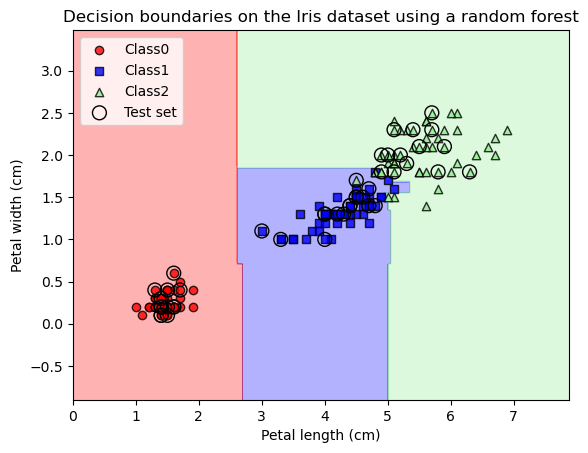

In [22]:
from sklearn.ensemble import RandomForestClassifier
forest= RandomForestClassifier(n_estimators=25, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx= range(105,150))
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.legend(loc='upper left')
plt.tight_layout
plt.title('Decision boundaries on the Iris dataset using a random forest')
plt.show()

## K-nearest neighbors - A lazy learning algorithm

It is called “lazy” not because of its apparent simplicity, but because it doesn’t learn a discriminative function from the training data but memorizes the training dataset instead.


Text(0.5, 1.0, 'k-nearest neighbors’ decision boundaries on the Iris dataset')

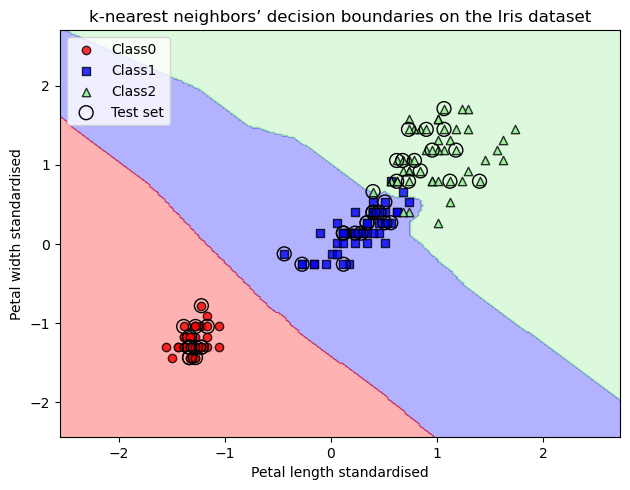

In [27]:
# using an euclidean distance metric implementing KNN

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski') #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105, 150))
plt.xlabel('Petal length standardised')
plt.ylabel('Petal width standardised')
plt.legend(loc='upper left')
plt.tight_layout()
plt.title('k-nearest neighbors’ decision boundaries on the Iris dataset')


#####  If the neighbors have similar distances, the algorithm will choose the class label that comes first in the training dataset.

The minkowski distance that we used in the previous code is just a generalization of the Euclidean and Manhattan distance.

KNN is sensitive to feature scaling because it uses distances between points for classification.
Random Forest is not sensitive to feature scaling because it makes splits based on thresholds, not distances.